# MyAcrobot
my custom acrobot rl model for learning, this will have an extended custom environment

### Create my virutal environment

#

pip install virtualenv
virtualenv myenv
source myenv/bin/activate
pip install numpy pandas matplotlib
pip install ipykernel
python -m ipykernel install --user --name=myenv --display-name "Python (myenv)"



pip install virtualenv virtualenv myenv source myenv/bin/activate pip install numpy pandas matplotlib pip install ipykernel python -m ipykernel install --user --name=myenv --display-name "Python (myenv)" 

## Model Code

In [16]:
!pip install gymnasium
!pip install gymnasium[classic-control]
!pip install gymnasium[box2d]
!pip install torch

  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached swig-4.2.1.post0-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata (3.5 kB)
Using cached swig-4.2.1.post0-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.8 MB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [16 lines of output]
      Using setuptools (version 75.2.0).
      /app/myenv/lib/python3.9/site-packages/setuptools/_distutils/dist.py:261: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      running bdist_wheel
      running build
      running build_py
      creating build/lib.linux-x86_64-cpython-39/Box2D
      copying library/Box2D/__init__.py -> build/lib.linux-x86_64-cpython-39/Box2D
      copying library/Box2D/Box2D.py -> build/lib.linux-x86_64-cpython-39/Box2D
      creating build/lib.linux-x86_64-cpython-39/Box2D/b2
      copying library

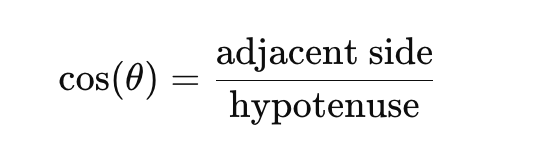

In [17]:
from IPython.display import Image
Image(filename='./images/cos.png', width=500) 

#Scientific Notation

-i pasted this here cause i saw some outputs with e tag. i wanted to know if that was bad to see the e in the state and is a good thing to see.

scientific notation


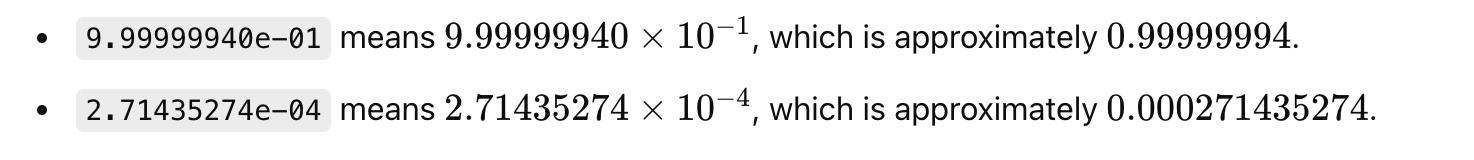

In [18]:
from IPython.display import Image
print("scientific notation")
Image(filename='./images/scientific-notation.png', width=500) 

### to get ai out of mmindless state we implement a reinforcement learning algorithm.


rl algorithm choices


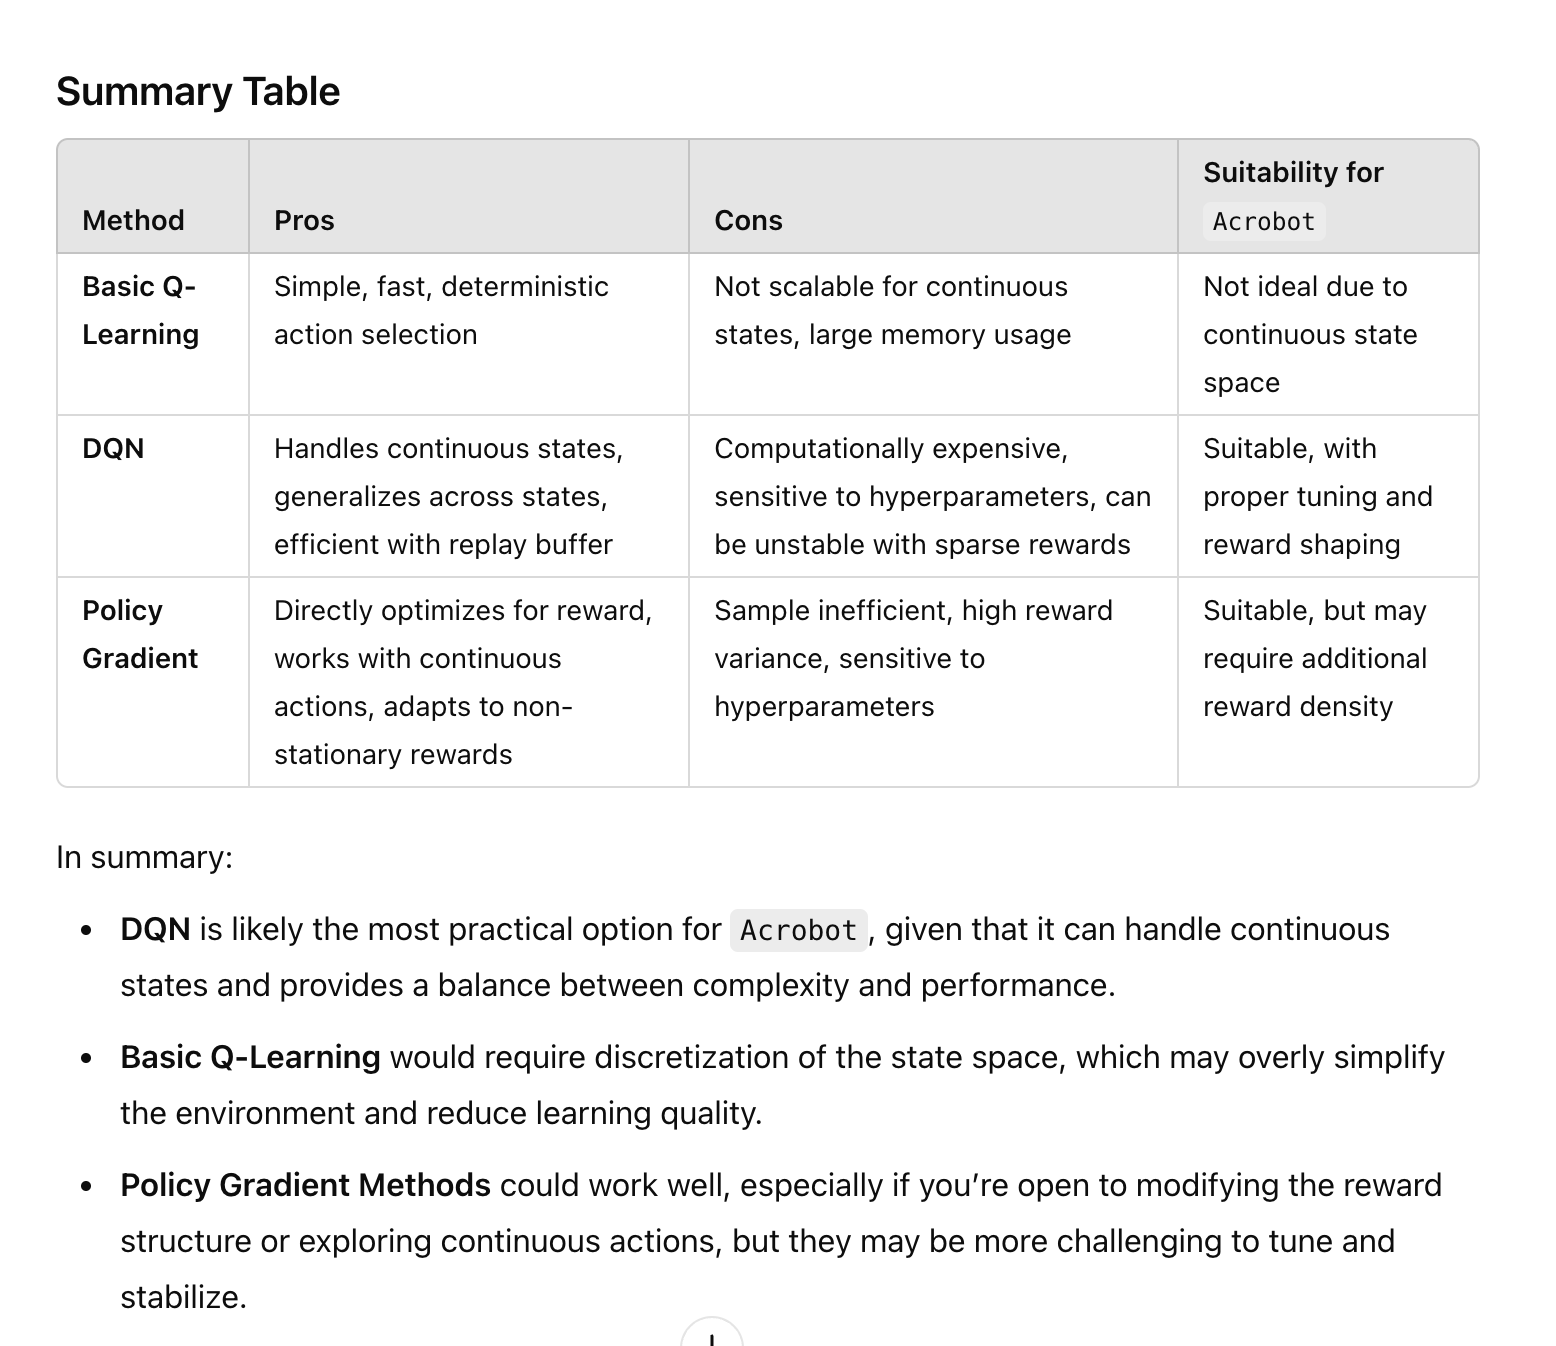

In [19]:
from IPython.display import Image
print("rl algorithm choices")
Image(filename='./images/rl-alog-types-for-this-model.png', width=500) 

In [20]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

In [21]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x): # the brain of the agent, pushes the data through the 3 layers, pytorch auto does this
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [22]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def size(self):
        return len(self.buffer)

In [26]:
class DQNAgent:
    def __init__(self, env, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, lr=0.001, buffer_size=10000, batch_size=64, target_update_freq=10):
        self.env = env  # environment for the agent
        self.gamma = gamma  # discount factor for future rewards
        self.epsilon = epsilon  # initial exploration rate
        self.epsilon_min = epsilon_min  # minimum exploration rate
        self.epsilon_decay = epsilon_decay  # rate of epsilon decay
        self.lr = lr  # learning rate for optimizer
        self.buffer_size = buffer_size  # maximum replay buffer size
        self.batch_size = batch_size  # training batch size
        self.target_update_freq = target_update_freq  # frequency of target updates

        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n

        # Define the networks
        self.policy_network = DQN(self.state_dim, self.action_dim)
        self.target_model = DQN(self.state_dim, self.action_dim)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=self.lr)

        # Initialize replay buffer
        self.replay_buffer = ReplayBuffer(self.buffer_size)

        # Synchronize target model with the main model
        self.update_target_model()

    def update_target_model(self):
        self.target_model.load_state_dict(self.policy_network.state_dict())

    def pick_next_action(self, state):
        if np.random.rand() <= self.epsilon: # this grabs a random value
            return self.env.action_space.sample()
        else:
            # convert state into a tensor for pytorch, we do this cause pytorch likes tensors
            state = torch.FloatTensor(state).unsqueeze(0) # we unsqueeze for pytorch, its a thing we have to do
            with torch.no_grad(): # Disables gradients for this part of the code, saves memory cause we are not learning
                q_values = self.policy_network(state) # this hits the forward method
            return torch.argmax(q_values).item() # returns the highest q value

    def train(self):
        if self.replay_buffer.size() < self.batch_size:
            return
        print("buffer size is large enough")
        # Sample a batch from the replay buffer
        batch = self.replay_buffer.sample(self.batch_size) # this is past experiences
        states, actions, rewards, next_states, dones = zip(*batch) # unzips the experiences 
        
        
        print("after unzip batch")
        
        # convert all to pytorch tensors
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        # Compute Q targets for current states
        q_values = self.policy_network(states).gather(1, actions.unsqueeze(1)).squeeze(1) # calls forward method retunring q values, squeen remogves the extra dimension, .gather picks the q value for the actual action
        # Compute Max Q-Values for Next States (Target Network):
        with torch.no_grad(): # save memory no gradients
            max_next_q_values = self.target_model(next_states).max(1)[0]
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones) # Calculates the Q-targets for the current states.

        # Compute loss
        loss = nn.functional.mse_loss(q_values, q_targets)

        # Backpropagation, which updates the models parameteres, updates teh weights and biases of the network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon, reduce exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay



In [24]:
import gymnasium as gym
import numpy as np
from gymnasium.envs.classic_control.acrobot import AcrobotEnv

class CustomAcrobotEnv(AcrobotEnv):
    def __init__(self, render_mode='rgb_array', link_length_1=1.0, link_length_2=1.0):
        super().__init__()
        self.render_mode = render_mode
        self.link_length_1 = link_length_1
        self.link_length_2 = link_length_2

    def calculate_y_endpoint(self, state, link_length_1, link_length_2):
        """
        Calculate the y-coordinate of the acrobot's endpoint based on the state.
        Assumes `state` contains cos(theta1), sin(theta1), cos(theta2), sin(theta2).
        """
        # Extract angles from the state
        theta1 = np.arctan2(state[1], state[0])  # Calculate theta1 from sin and cos
        theta2 = np.arctan2(state[3], state[2])  # Calculate theta2 from sin and cos

        # Calculate y position of the endpoint
        y = -link_length_1 * np.cos(theta1) - link_length_2 * np.cos(theta1 + theta2)

        return y

    def step(self, action):
        # Call the original step method to perform the action
        state, reward, done, info, _ = super().step(action)
        
        # Calculate the y position of the endpoint
        y = self.calculate_y_endpoint(state, self.link_length_1, self.link_length_2)
        
        # Custom reward logic
        angle_threshold = 0.9  # Set a goal angle for high rewards
        angle = state[0]  # Assuming this represents the angle from the state

        # Apply custom reward conditions
        if angle > angle_threshold:
            reward = 10  # High reward for reaching a high angle
        elif abs(angle) < 0.1:
            reward = -1  # Penalty for low movement
        else:
            reward = -0.5  # Minor penalty for each step to keep it efficient
        
        # Optionally, add custom information or logging
        #info['custom_reward'] = reward
        return state, reward, done, info

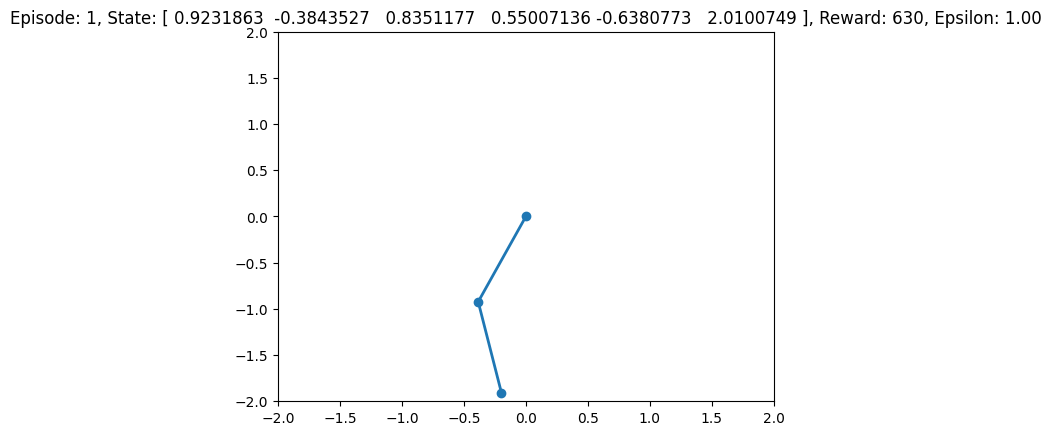

buffer size is large enough
after unzip batch


ValueError: expected sequence of length 6 at dim 1 (got 2)

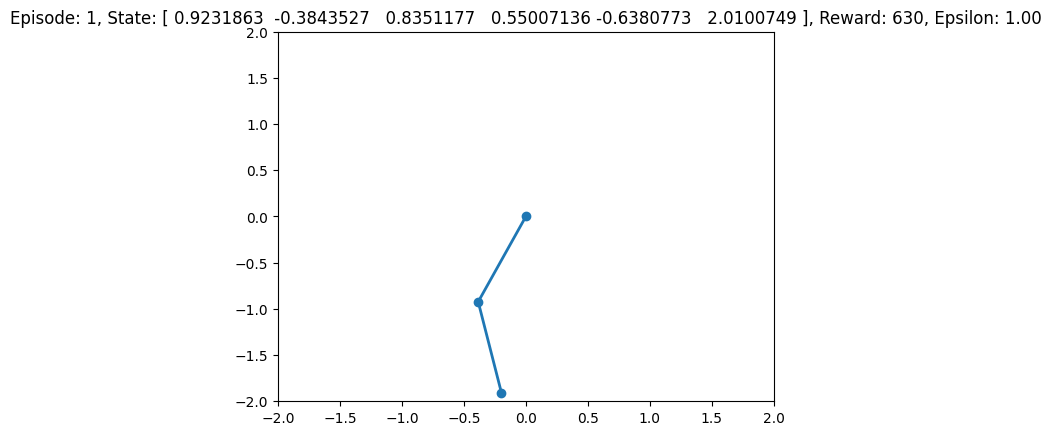

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import time

# Instantiate and use the custom environment
env = CustomAcrobotEnv(render_mode='rgb_array')
agent = DQNAgent(env)
#state = env.reset()

# Initialize a figure
fig, ax = plt.subplots()
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.axis('on')

# Plot components
line, = ax.plot([], [], 'o-', lw=2)

# Parameters
num_episodes = 100  # Total episodes to train and visualize
episode_rewards = []  # Track rewards for each episode

# Function to convert state to (x, y) coordinates
def get_coords(state):
    # Length of each link in Acrobot
    link_length = 1.0
    
    # Calculate theta1 and theta2 from cos/sin values in the state
    theta1 = np.arctan2(state[1], state[0])
    theta2 = np.arctan2(state[3], state[2])

    # Calculate joint positions
    x0, y0 = 0, 0  # Base position (fixed)
    x1 = link_length * np.sin(theta1)
    y1 = -link_length * np.cos(theta1)
    x2 = x1 + link_length * np.sin(theta1 + theta2)
    y2 = y1 - link_length * np.cos(theta1 + theta2)

    return [(x0, y0), (x1, y1), (x2, y2)]

# Define an update function for each frame, this is the agent in a mindless state
def update_frame():
    global state
    for _ in range(2):
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        
        # Get joint coordinates from the state
        coords = get_coords(state)
        x_vals, y_vals = zip(*coords)
        
        # Update the line data
        line.set_data(x_vals, y_vals)
        ax.set_title(f'State: {state}, Reward: {reward}')
        
        clear_output(wait=True)
        display(fig)
        
        time.sleep(0.2)

        if done:
            state = env.reset()

# Run the update function in a loop, this is putting the agent in a mindless state
# env.reset()
# for _ in range(100):
#     update_frame()


# Training and visualization loop
for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0  # Total reward for this episode

    while not done:
        # Select action based on the agent's policy
        action = agent.pick_next_action(state)

        # Take the action in the environment
        next_state, reward, done, info = env.step(action)

        # Store the experience and train the agent
        agent.replay_buffer.push(state, action, reward, next_state, done)
        agent.train()

        # Update state and accumulate reward
        state = next_state
        total_reward += reward

        # Get joint coordinates from the current state
        coords = get_coords(state)
        x_vals, y_vals = zip(*coords)

        # Update the line data for visualization
        line.set_data(x_vals, y_vals)
        ax.set_title(f"Episode: {episode + 1}, State: {state}, Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")
        
        # Render the updated frame
        clear_output(wait=True)
        display(fig)
        time.sleep(0.02)

    # Store the total reward for this episode
    episode_rewards.append(total_reward)

    # Update target network periodically
    if episode % agent.target_update_freq == 0:
        agent.update_target_network()

    # Decay epsilon after each episode
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

# Close the environment
env.close()

# plot training progress
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress")
plt.show()



### TODO TIM!! what i need do is start writing my rl algorithm and then use the custom environment to test it out.

#### TODO TIM work on teh caluculate reoward, we are passing in the length of each line so we need to set in the custom environment
### and the reward will be based around that



#### TODO TIM!!!! we need to do a print statement to see whats in the being stored in memory buffer, put this in print statement cause code fails when the memory is full and tries to unpack



In [ ]:
num_episodes = 500
sync_target_steps = 10  # Update target model every 10 episodes

env = CustomAcrobotEnv()
agent = DQNAgent(env)

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.select_action(state)
        next_state, reward, done, info = env.step(action)
        agent.replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        # Train the agent
        agent.train()

    # Update target model
    if episode % sync_target_steps == 0:
        agent.update_target_model()

    print(f"Episode {episode+1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.4f}")

env.close()


AttributeError: 'DQNAgent' object has no attribute 'select_action'

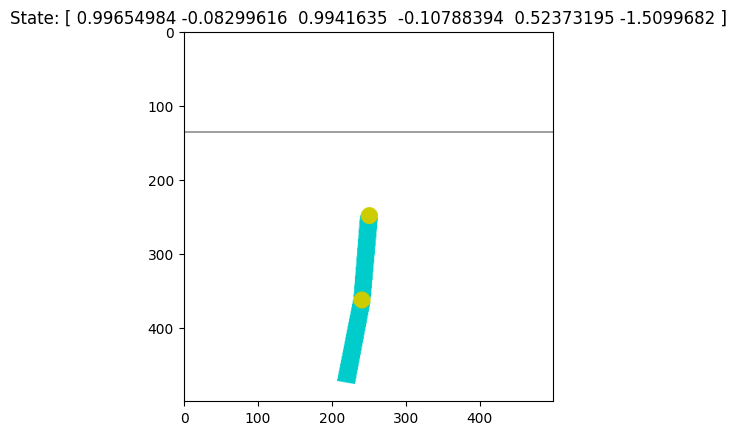

KeyboardInterrupt: 

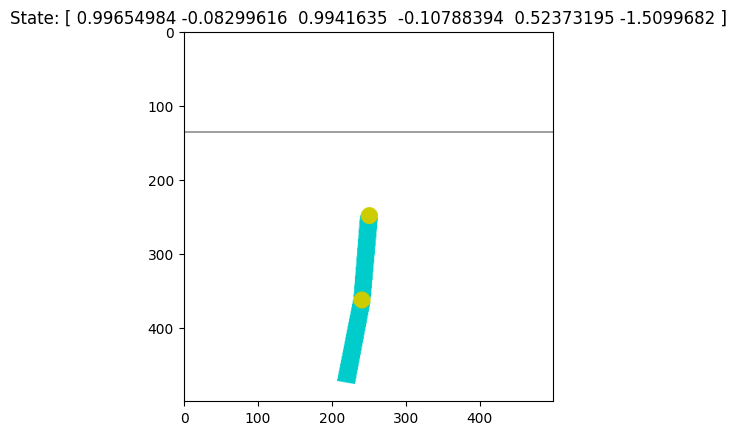

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Now you can instantiate and use your CustomAcrobotEnv like a standard Gymnasium environment
env = CustomAcrobotEnv(render_mode='rgb_array')
state = env.reset()

# Initialize a figure
fig, ax = plt.subplots()
img = env.render()
im = ax.imshow(img)
ax.axis('on')

# Define an update function for the animation
def update_frame():
    global state
    # Loop through actions for each frame update
    for _ in range(2):  # Adjust the range to control how many steps per frame
        action = env.action_space.sample()  # Sample a random action
        state, reward, done, info = env.step(action)  # Take a step in the environment
        print(f'State: {state}, Reward: {reward}, Done: {done}, Info: {info}')
        
        # Render the new frame
        img = env.render()
        im.set_array(img)
        
        # Update the title with the current state
        ax.set_title(f'State: {state}')
        
        # Display the updated plot
        clear_output(wait=True)
        display(fig)
        
        time.sleep(0.2)  # Adjust this delay to control the speed of the display
        
        # Reset if done
        if done:
            state = env.reset()

# Run the update function in a loop for a certain number of frames
for _ in range(100):  # Adjust the number of frames as needed
    update_frame()

# Close the environment
env.close()


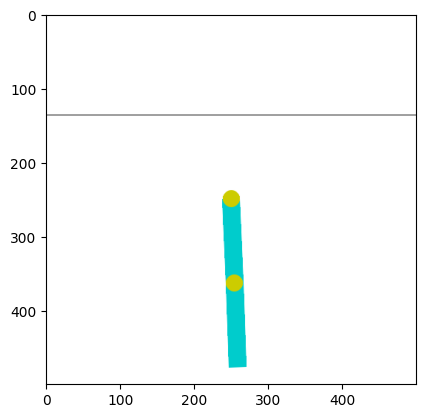

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

# Set up the environment
env = gym.make('Acrobot-v1', render_mode='rgb_array')
state = env.reset()

# Initialize a figure
fig, ax = plt.subplots()
img = env.render()
im = ax.imshow(img)
ax.axis('on')  

# Define an update function for the animation
def update_frame(frame):
    global state
    # Loop through actions for each frame update
    for _ in range(2):  # Adjust the range to control how many steps per frame
        action = env.action_space.sample()  # Sample a random action
        state, reward, done, info, _ = env.step(action)  # Take a step in the environment
        print(f'State: {state}, Reward: {reward}, Done: {done}, Info: {info}')
        
        # Render the new frame
        img = env.render()
        im.set_array(img)
        print("image updated")


        plt.title(f'State: {state}')  # Update title with current state
             
        time.sleep(2)
        # Reset if done
        if done:
            state = env.reset()

    return [im]

# Create the animation
#ani = FuncAnimation(fig, update_frame, frames=100, blit=True, interval=200)  # interval controls the speed

# Display the animation
plt.show()

# Close the environment
env.close()

Length of action space: 3
action is  0
State: [ 0.99816144 -0.06061121  0.99996805 -0.00799556  0.29302087 -0.47871965], Reward: -1.0, Done: False, Info: False
action is  1
State: [ 0.99999774  0.00212145  0.9946771  -0.10304102  0.3189883  -0.4473972 ], Reward: -1.0, Done: False, Info: False
action is  2
State: [ 0.9988793   0.04733011  0.98986226 -0.14203078  0.12327641  0.06734679], Reward: -1.0, Done: False, Info: False
action is  1
State: [ 0.99803513  0.06265686  0.9939863  -0.10950462  0.02820571  0.25708857], Reward: -1.0, Done: False, Info: False
action is  1
State: [ 0.998273    0.05874499  0.9990824  -0.04282941 -0.06441435  0.3994411 ], Reward: -1.0, Done: False, Info: False
action is  0
State: [0.99863416 0.05224755 0.9999561  0.00937579 0.00217835 0.11298083], Reward: -1.0, Done: False, Info: False
action is  2
State: [ 0.99944216  0.03339766  0.9975989   0.06925666 -0.18485299  0.47255892], Reward: -1.0, Done: False, Info: False
action is  1
State: [ 0.9999912  -0.004193

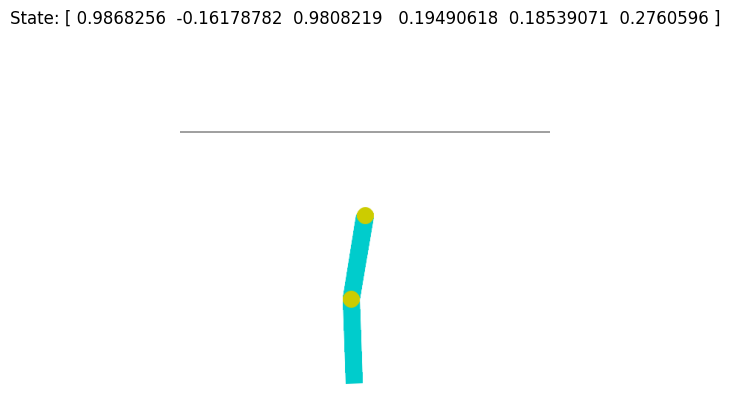

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Set up the environment
env = gym.make('Acrobot-v1', render_mode='rgb_array')
state = env.reset()

print("Length of action space:", env.action_space.n)

# Initialize a figure
fig, ax = plt.subplots()
img = env.render()
im = ax.imshow(img)
ax.axis('off')  # Turn off the axis

# Define a method to handle the state information and update the frame
def update_frame(frame):
    global state
    # Loop through actions for each frame update
    for _ in range(10):  # Adjust the range to control how many steps per frame
        action = env.action_space.sample()  # Sample a random action
        print("action is ", action)
        state, reward, done, info, _ = env.step(action)  # Take a step in the environment
        print(f'State: {state}, Reward: {reward}, Done: {done}, Info: {info}')
        # Reset if done
        if done:
            state = env.reset()

    # Render the new frame
    img = env.render()
    im.set_array(img)
    plt.title(f'State: {state}')  # Update title with current state

    return [im]

# Create the animation
ani = FuncAnimation(fig, update_frame, frames=100, blit=True, interval=50)  # interval controls the speed

# Display the animation
plt.show()

# Close the environment
env.close()


Initial state: (array([ 9.9970800e-01,  2.4163572e-02,  9.9638206e-01, -8.4987283e-02,
        3.6662940e-02, -8.5258915e-04], dtype=float32), {})
State: [ 0.99964356  0.02669787  0.99725956 -0.0739823  -0.01142294  0.10962421]


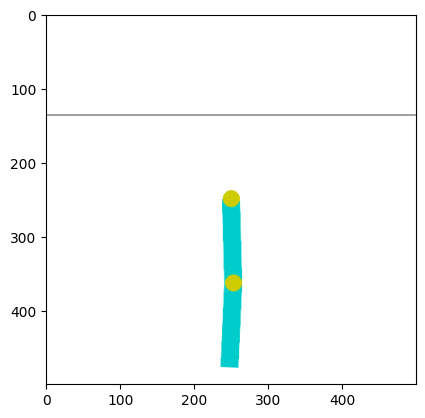

State: [ 0.9994457   0.03329246  0.9970257  -0.07706945  0.07582288 -0.13874911]
State: [ 0.9984638   0.05540808  0.99198824 -0.12633021  0.13937066 -0.3442176 ]
State: [ 0.99631727  0.0857435   0.97839975 -0.20672187  0.15594749 -0.45243794]
State: [ 0.99350023  0.11383034  0.9555198  -0.2949269   0.11791573 -0.43951663]
State: [ 0.9945771   0.10400168  0.9524752  -0.3046162  -0.21441878  0.33708426]
State: [ 0.99897075  0.04535891  0.9790924  -0.20341578 -0.3590016   0.68391764]
State: [ 0.9989799  -0.04515617  0.99988097 -0.0154277  -0.52220297  1.1635898 ]
State: [ 0.98852396 -0.15106422  0.9720323   0.23484726 -0.5118923   1.2990248 ]
State: [ 0.97477204 -0.2232029   0.9021747   0.43137088 -0.20373894  0.74931574]
State: [ 0.97101694 -0.23901069  0.84786266  0.53021586  0.04624191  0.3615418 ]
State: [ 0.9786722  -0.20542814  0.83252615  0.5539858   0.29126936 -0.07726539]
State: [ 0.99312234 -0.11708143  0.87781614  0.47899774  0.5848943  -0.77555776]
State: [ 0.9995643   0.02951

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt

# Create the Acrobot environment with render mode
env = gym.make('Acrobot-v1', render_mode='rgb_array')

# Reset the environment
state = env.reset()
print("Initial state:", state)

# Set up the Matplotlib figure and axis
fig, ax = plt.subplots()
img = env.render()  # Render the first frame
im = ax.imshow(img)  # Display the first frame

# Turn off the axis
#ax.axis('off')

# Function to update the frame
def update_frame():
    action = env.action_space.sample()  # Sample a random action
    state, reward, done, info, _ = env.step(action)  # Take a step in the environment
    
    img = env.render()  # Get the new frame
    im.set_data(img)  # Update the displayed frame
    fig.canvas.flush_events()  # Update the canvas with the new frame
    
    print("State:", state)
    
    return done

# Run the loop to animate the plot
plt.ion()  # Turn on interactive mode
for _ in range(100):  # Run for a fixed number of frames or until done
    done = update_frame()
    plt.pause(0.01)  # Pause to control the frame rate
    
    if done:
        state, _ = env.reset()  # Reset the environment if done

plt.ioff()  # Turn off interactive mode
env.close()  # Close the environment


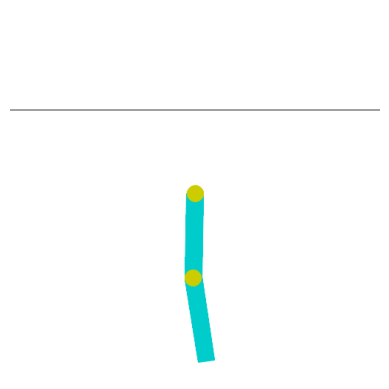

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create the Acrobot-v1 environment with render mode 'rgb_array'
env = gym.make('Acrobot-v1', render_mode='rgb_array')

# Reset the environment to the initial state
state, _ = env.reset()

# Set up the figure and axis
fig, ax = plt.subplots()
img = env.render()
im = ax.imshow(img)
plt.axis('off')  # Turn off the axis

def update(frame):
    global state
    action = env.action_space.sample()  # Sample a random action
    state, reward, done, _, info = env.step(action)  # Take a step in the environment

    img = env.render()  # Render the environment and get the image
    im.set_array(img)  # Update the image data

    if done:
        state, _ = env.reset()  # Reset the environment if done

    return [im]

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=200, blit=True, interval=50, repeat=True)

plt.show()

env.close()  # Close the environment